# Imports and Constants

In [1]:
import numpy as np
from datetime import datetime
import numpy as np
from math import floor
from utils import update_labels, master_path, get_answer_vector, hash_dataframe
from functools import partial
import torch
from torch import nn
from math import floor, ceil
import pandas as pd
from collections import Counter
from tqdm import tqdm
from matplotlib import pyplot as plt


CONNECTION_ON = False
MODEL = 'gpt-4o'  # 'gpt-4o' 'ollama' 'gpt-3.5-turbo' 
right_now = datetime.now().replace(microsecond=0, second=0)
label_col = 'json_response'
device = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'
seed = 42 # np.randint(0, 110)

mapping = lambda s: {'background': 'context',
                     'future_work': 'context',
                    'differences': 'context',
                     'future work': 'context',
                     'motivation': 'context',
                     'similarities': 'context',
                     'extends': 'uses',
                     '*': 'context'
                     }.get(s) or s


# Load existing or default dataframe, query LLM

In [2]:
lazy_copy = 'uniform_base_sample_ollama_prompt_2024-07-23 21/53/00'
total_questions = 40
other_path = f'~/Desktop/2. FutureTech/uniform_sample/results/{lazy_copy.replace('/',':')}.csv'
df = pd.read_csv(other_path) #update_labels(other_path, save = True)
df = df.sample(frac=1, random_state = seed).reset_index(drop=True)
df['answer_vector'] = df['json_response'].apply(partial(get_answer_vector, length = total_questions))
#df.rename(columns={'json_booleans':'json_response'}, inplace = True)
print(len(df))
df.head()


519


,Unnamed: 0.1,sentence,mcllm,modelKey,paperId,modelId_x,mc,modelId_y,mc_reduced,urop_sentence,...,labels,modelTitle,modelId,modelYear,paperYear,pot_extends,prob_extends,modelKeyStriped,json_response,answer_vector
0,275,NaN,NaN,915_gans,9a1c023d80550f899a1e6ebfbc6f3579194634a8,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,gans,"{""answer_1"": ""False"", ""answer_2"": ""False"", ""an...","[0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,93,private models were provided by anthropic (mod...,background,529_chinchilla,31d65e179b1d00484154b3525d93846dd82f23d8,8342b592fe238f3d230e4959b06fd10153c45db1,uses,8342b592fe238f3d230e4959b06fd10153c45db1,uses,private models were provided by anthropic (mod...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,chinchilla,"{""answer_1"": ""False"", ""answer_2"": ""False"", ""an...","[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, ..."
2,6,"considering the first goal, a language model t...",background,529_chinchilla,362cbfd0d05e139cd6cf049754098a6e1520b910,8342b592fe238f3d230e4959b06fd10153c45db1,background,8342b592fe238f3d230e4959b06fd10153c45db1,context,"considering the first goal, a language model t...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,chinchilla,"{""answer_1"": ""False"", ""answer_2"": ""False"", ""an...","[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,167,our work does not rely on the underlying netwo...,uses,120_mobilenet,a7a8c37d4c3d652ddb53fee6d35c064dae77a986,3647d6d0f151dc05626449ee09cc7bce55be497e,extends,3647d6d0f151dc05626449ee09cc7bce55be497e,extends,our work does not rely on the underlying netwo...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,mobilenet,"{""answer_1"": ""False"", ""answer_2"": ""False"", ""an...","[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, ..."
4,90,to alleviate the inconsistence of the pretrain...,uses,1064_bert-large,5c712ffbebac2ac7c50fdc542b9a3fb92d06bfc9,df2b0e26d0599ce3e70df8a9da02e51594e0e992,uses,df2b0e26d0599ce3e70df8a9da02e51594e0e992,uses,to alleviate the inconsistence of the pretrain...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,bert-large,"{""answer_1"": ""False"", ""answer_2"": ""False"", ""an...","[0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, ..."


In [3]:
df = df[df['answer_vector'].notna()]

In [4]:
split = floor(.5 * len(df))
print(f"Test-train split: {split}, {len(df) - split}")

df_train, df_test = df.iloc[:split], df.iloc[split:]

 
label_mask = lambda s: df_train['alex2'].apply(mapping) == s
labels = sorted(list({mapping(item) for item in ['background', 'extends', 'uses']}))
per_label_samples = max([len(df_train[label_mask(label)]) for label in labels])
per_label_multipliers = [ceil(per_label_samples/len(df_train[label_mask(label)])) for label in labels]


#comment out this line to use the original distribution
df_train = pd.concat([df_train[label_mask(label)] for label, multiplier in zip(labels, per_label_multipliers) for _ in range(0, multiplier)])
print(f"Training size {len(df_train)}")

Test-train split: 259, 260
Training size 399


# Creating a model!

In [5]:
X_train, y_train = (np.random.RandomState(seed=seed).permutation(np.stack(df_train['answer_vector'])), 
                        np.random.RandomState(seed=seed).permutation(np.array(df_train['alex2'].apply(mapping).apply(lambda s: {'context': 0, 'uses': 1, 'extends': 2}.get(s))))
                )

X_train = torch.tensor(X_train, dtype = torch.float32)
y_train = torch.tensor(y_train, dtype = torch.float32).reshape(-1, 1)


X_test = torch.tensor(np.stack(df_test['answer_vector']), dtype = torch.float32)
y_test = torch.tensor(np.array(df_test['alex2'].apply(mapping).apply(lambda s: {'context': 0, 'uses': 1, 'extends': 2}.get(s))), dtype = torch.float32).reshape(-1, 1)
print("Training shape:", X_train.shape, y_train.shape)
print("Testing shape:", X_test.shape, y_test.shape)

c = Counter([el.item() for el in y_test])
print(f"Background composition: {c[0]/len(df_test)}")


Training shape: torch.Size([399, 40]) torch.Size([399, 1])
Testing shape: torch.Size([260, 40]) torch.Size([260, 1])
Background composition: 0.6961538461538461


In [6]:

model = nn.Sequential(
        nn.Linear(total_questions, 64), nn.ReLU(),
        nn.Dropout(.5),
        nn.LazyLinear(32), nn.ReLU(),
        nn.Dropout(.5),
        nn.LazyLinear(16), nn.ReLU(),
        nn.LazyLinear(len(labels)), nn.Softmax(dim = 1)
)



loss_fn = nn.CrossEntropyLoss()

model = model.to(device) # device = 'mps'
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

/opt/miniconda3/lib/python3.12/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [7]:
def train_model(model, verbose = False, iters = 1000, lr = 1e-3):
    lr = lr * 10 # hacky and stupid
    learning_rate_horizons = {0, 100, 500}
    train_accuracies, test_accuracies = [], []
    
    
    
    for epoch in range(iters):
        if (epoch in learning_rate_horizons):
            lr = lr / 10
            print(f"lr: {lr}")
            optimizer = torch.optim.Adam(params = model.parameters(), lr = lr)

        output = model(X_train)
        loss = loss_fn(output, y_train.reshape(-1,))
        
    
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_accuracy = (output.argmax(dim = 1) == y_train.reshape(-1, )).sum().item()/len(y_train)
        test_accuracy = (model(X_test).argmax(dim = 1) == y_test.reshape(-1,)).sum().item()/len(y_test)
        
        train_accuracies.append(train_accuracy)
        test_accuracies.append(test_accuracy)

        if (epoch % 100 == 0 and verbose):
            print(f"Epoch: {epoch}, train loss: {loss.item()}, train acc: {train_accuracy}, test ac {test_accuracy}")
            
    
    return train_accuracies, test_accuracies


train_accuracies, test_accuracies = train_model(model, verbose=True, iters = 1000)

lr: 0.001
Epoch: 0, train loss: 0.6974002122879028, train acc: 0.47368421052631576, test ac 0.6961538461538461
lr: 0.0001
Epoch: 100, train loss: 0.6058480143547058, train acc: 0.6967418546365914, test ac 0.5615384615384615
Epoch: 200, train loss: 0.5958714485168457, train acc: 0.7017543859649122, test ac 0.5307692307692308
Epoch: 300, train loss: 0.5772969722747803, train acc: 0.7443609022556391, test ac 0.5384615384615384
Epoch: 400, train loss: 0.572259783744812, train acc: 0.7268170426065163, test ac 0.6153846153846154
lr: 1e-05
Epoch: 500, train loss: 0.5421899557113647, train acc: 0.7794486215538847, test ac 0.5307692307692308
Epoch: 600, train loss: 0.5437362194061279, train acc: 0.7844611528822055, test ac 0.5615384615384615
Epoch: 700, train loss: 0.5422729849815369, train acc: 0.7819548872180451, test ac 0.5653846153846154
Epoch: 800, train loss: 0.5319798588752747, train acc: 0.8170426065162907, test ac 0.55
Epoch: 900, train loss: 0.5521755218505859, train acc: 0.7468671679

In [14]:
ts = [0, .05, .25, .66, .90, .98, .99, .999, 1]
def run_model(v, threshold = .98):
    if v is None:
        return None
    
    ten = torch.Tensor(v).to(device).reshape(1, -1)
    rankings = model(ten).to('cpu').detach().numpy().reshape(-1, )
    classification = rankings.argmax()
    
    if (rankings[classification] >= threshold):
        return {0: 'context', 1:'uses', 2:'extends'}.get(classification) 
    
    return 'context'

df['learned_classification'] = df['answer_vector'].apply(run_model)
df.to_csv(other_path, index = False)

In [9]:
print(test_accuracies[-1])
print(Counter(df['learned_classification']))
print(f"Test labels hash: {hash_dataframe(list(df_test['alex2']))}")


0.55
Counter({'context': 441, 'uses': 78})
Test labels hash: b'3\x01-\xb3\xc8\xd0&\x88\x8cH\x8d\x80\x80\xe5\xf0\xba'


 95%|█████████▌| 19/20 [00:04<00:00,  3.92it/s]/var/folders/6j/9qz49mv9637bsngvd04d4pf00000gp/T/ipykernel_94986/386671220.py:11: RuntimeWarning: invalid value encountered in scalar divide
  uses_fp = (pred_uses & true_context).sum()/pred_uses.sum()
100%|██████████| 20/20 [00:05<00:00,  3.93it/s]


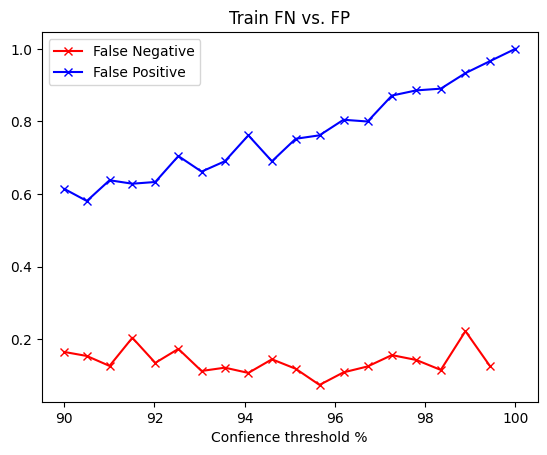

In [10]:
def pareto_plot(X, y, start = .9, end = 1, num = 20, verbose = False, test_or_train = "Test"):
    fps, fns = [], []
    thresholds = np.geomspace(start, end, num = num)

    for t in tqdm(thresholds):
        pred = np.array([run_model(X[v,:], threshold = t) for v in range(len(X))])
        (pred_uses, pred_context) = (pred == 'uses', pred == 'context')
        (true_uses, true_context) = (y.reshape(-1,).cpu().numpy() == 1, y.reshape(-1,).cpu().numpy()  == 0)
        
        
        uses_fp = (pred_uses & true_context).sum()/pred_uses.sum() 
        uses_fn = (true_uses & pred_context).sum()/true_uses.sum()
        
        if verbose:
            print(f"Threshold: {t}, FP: {uses_fp}, FN:{uses_fn}")
        
        fps.append(uses_fp)
        fns.append(uses_fn)
    
    plt.title(f"{test_or_train} FN vs. FP")
    plt.plot(thresholds * 100,fps, 'xr-')
    plt.plot(thresholds * 100,fns, 'xb-')
    plt.legend(['False Negative', 'False Positive'])
    plt.xlabel("Confience threshold %")
    
pareto_plot(X_train, y_train, verbose = False, test_or_train = "Train")


 95%|█████████▌| 19/20 [00:03<00:00,  6.27it/s]/var/folders/6j/9qz49mv9637bsngvd04d4pf00000gp/T/ipykernel_94986/386671220.py:11: RuntimeWarning: invalid value encountered in scalar divide
  uses_fp = (pred_uses & true_context).sum()/pred_uses.sum()
100%|██████████| 20/20 [00:03<00:00,  5.97it/s]


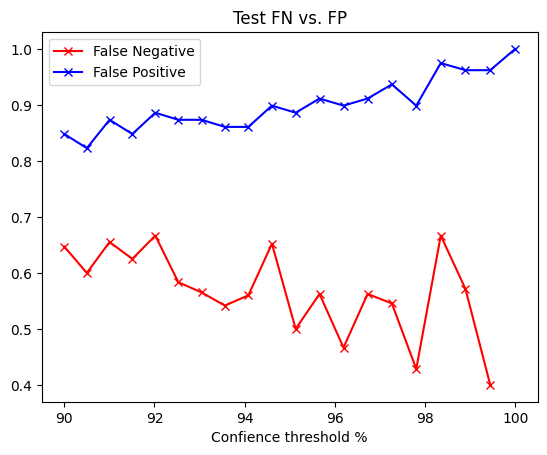

In [11]:
pareto_plot(X_test, y_test, test_or_train = "Test")
